In [2]:
import numpy as np
import scipy.optimize
import control
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import math
import PIL.Image
plt.style.use('dark_background')

In [3]:
M1 = 0.560 # 0.350 # kg
M2 = 0.052
G = 9.8 # N/kg
# E0 = 0.32722 # J
Vref = 2 * math.pi / (0.12 * 6) # 2 * math.pi / (0.1 * 6)
Pmax = (2.9 / 2) * (Vref / 2) # JX B70 servo max power

K = np.linspace(385 / 2, 385 * 1.5, 20)
Vmax = np.linspace(Vref / 2, Vref * 4, 20) # rad/s

Tstall = Vmax * (Pmax / (Vmax / 2) ** 2)
R = 0.01

In [130]:
# when the middle node is not massless, the equation solving goes the other direction and gets more complicated
# our state becomes { t1, z1, dz1, z2, dz2 } and we need to solve dt1 in terms of the linear positions/velocities (dz1 - dz2 gives us the sign of dt1)
# then we get the permissible torque from the torque-speed curve, which is then converted to linear force applied to both the middle link (z2) and the upper body (z1)
# spring force of course remains -k*z2
# that becomes the physics model, which is considerably more complicated: worth just throwing into gazebo, may build it here idk
# at least tau -> spring has already been done for us in the invertible equation there
# dt1 though is a fresh equation we need to figure out. Although it seems like it would be a similar conversion since it is just trigonometry...
# to conserve power it should just be the reciprocal
class BotPhysics:
    R1, R2, W = (0.04, 0.03, 0.04)
    M1 = 0.560 # 0.350 # kg
    M2 = 0.052
    Ff = 0
    # k, vmax and tau_stall are mandatory
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        self.Mtot = self.M1 + self.M2
    
    def mech_adv(self, t1):
        t2, phi = self.angle_solve(t1)
        return np.sin(t2) * np.sin(phi) / self.R1 # (np.cos(t1) - np.cos(t2) * np.sin(phi)) / self.R1
    
    def angle_solve(self, t1):
        t2_arg = (self.W - self.R1 * np.cos(t1)) / self.R2
        t2 = np.arccos(np.minimum(t2_arg, 1))
        phi = t1 + (math.pi - t2) # t2 + (math.pi - t1)
        return (t2, phi)

    def piston_height(self, t1):
        t2, phi = self.angle_solve(t1)
        return self.R1 * np.sin(t1) + self.R2 * np.sin(t2)

    def nl_ode(self, d_ = True, tdelay = 0):
        def nl_ode_(t, x):
            t1, z1, dz1, dz2 = x
            # derived parameters
            z2 = z1 - self.piston_height(t1)
            Fsp = -self.k * z2

            # Fj = Fsp
            # Fj = tau_1 / R1 * (math.cos(t1) - math.cos(t2) * math.sin(phi))
            # =>
            t2, phi = self.angle_solve(t1)
            mech_adv = self.mech_adv(t1)
            dt1 = (dz1 - dz2) * mech_adv
            tau_1 = (1 - dt1 / vmax) * self.tau_stall
            Fservo = tau_1 * mech_adv
            
            # accels
            servo_sp_x0 = 0.0761 # m
            F_servo_sp = (servo_sp_x0 - self.piston_height(t1)) * 893
            ddz2 = (Fsp - Fservo - Ff * np.sign(dz2) - F_servo_sp) / self.M2 - G
            ddz1 = (Fservo - Ff * np.sign(dz1) + F_servo_sp) / self.M1 - G
            
            zeroed = (t2 == 0) | ((t1 <= 0) & (dt1 < 0)) | (t < tdelay) | (t1 >= np.arccos(self.W / (self.R1 + self.R2))) # np.logical_or(t2_arg >= 1, np.logical_and(t1 <= 0, dt1 < 0)) # second clause for endstop
#             print(t, x, (t2 == 0), t1, dt1, (t < tdelay), (t1 >= np.arccos(self.W / (self.R1 + self.R2))))
            dz = np.mean([dz1, dz2])
            ddz_zero = (Fsp - Ff * np.sign(dz)) / self.Mtot - G
            try: # if not isinstance(dt1, (int, float, complex)) and dt1.size > 1:
                dt1[zeroed] = 0
                tau_1[zeroed] = 0
                ddz2[zeroed] = ddz_zero[zeroed]
                ddz1[zeroed] = ddz_zero[zeroed]
            except (TypeError, IndexError) as _e:
                if zeroed:
                    dt1 = 0
                    tau_1 = 0
                    ddz2 = ddz_zero
                    ddz1 = ddz_zero

            # ---
            # tau_1 = tau_stall * (1 - dt1 / vmax)
            # =>

            # solving for derivatives
            if d_:
                return [
                    dt1,
                    dz1,
                    ddz1,
                    ddz2
                ]
            else:
                return [t1, t2, dt1, tau_1, Fsp, z1, dz1, z2] # [phi, t1, dt1, tau_1, Fsp, t2, z1, dz1, z2]

        return nl_ode_ # lambda _, x: 

        # IGNORE:
    #     tau_2 = math.sin(phi) * tau_1 * R2 / R1
    #     dz1 = dz2 + (dt1 * R1 * math.cos(t1) + dt2 * R2 * math.cos(t2))
    #     ddz1 = ddz2 + (
    #         ddt1 * R1 * math.cos(t1) - (dt1 ** 2) * R1 * math.cos(t1) * math.sin(t1)
    #         + ddt2 * R2 * math.cos(t2) - (dt2 ** 2) * R2 * math.cos(t2) * math.sin(t2)
    #     )

In [138]:
k = 473
vmax0 = (60 / 0.11) * math.pi / 180
e0 = 0.5
# z2_0 = (G * M + np.sqrt((G * M) ** 2 + 2 * k * e0)) / k
tstall0 = 35.0 / 9.8 # stall torque

Efs = []
solss = []
vmax_mults = [1] # np.logspace(0, 1, 10)
for mult in vmax_mults:
    vmax = vmax0 * mult
#     tstall = tstall0 / mult
    tstall = tstall0
    Ffs = np.linspace(0, 3.5, 7) * 0.65
#     Ff = 2.6 # Ffs[]
    
    M2s = [0.053] # M1 * np.logspace(-2.5, 0, 10)
    for M2 in M2s:
        P = BotPhysics(k=k, tau_stall=tstall, vmax=vmax, Ff=Ff, M1=M1, M2=M2)
        
        Tnat = 2 * math.pi * math.sqrt(P.Mtot / k) # natural period
        Tbottom = Tnat / 4
        tdelays = np.linspace(-1 / 4, 1 / 2, 15)

        EPSILON = 1e-4 # 100u of epsilon
        # Ep0 = (Mtot * G) ** 2 / k
        t0 = 0 # theta-naught
        z1_0 = P.piston_height(t0) - EPSILON
        dz1_0 = -math.sqrt(2 * e0 / P.Mtot)
        dz2_0 = dz1_0
        
        for Ff in Ffs:
            print(M2, Ff)
            sols = []

            for tdelay in tdelays:
        #     tdelay = tdelays[0]
                f_stop = lambda t, x: (t < Tnat * 2) and (x[1] - P.piston_height(x[0])) # extract z2
                f_stop.terminal = True
                sol = scipy.integrate.solve_ivp(P.nl_ode(True, tdelay * Tnat + Tbottom), (0, Tnat * 2), [t0, z1_0, dz1_0, dz2_0], rtol=1E-5, events=f_stop)
                sols.append(sol)
    #             break

            Efs.append(np.array([(sol.y[2,-1] ** 2 * P.M1 + sol.y[3,-1] ** 2 * P.M2) / 2 + (sol.y[1,-1] - z1_0) * G * P.Mtot for sol in sols]))
            solss.append(sols)
#         break

0.053 0.0
0.053 0.3791666666666667
0.053 0.7583333333333334
0.053 1.1375
0.053 1.5166666666666668
0.053 1.8958333333333335
0.053 2.275


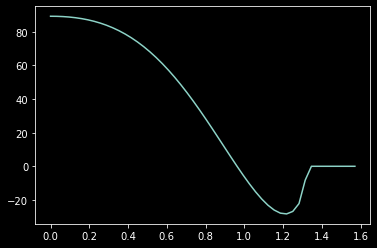

In [9]:
theta = np.linspace(0, math.pi / 2)
F = tstall0 * P.mech_adv(theta)
plt.plot(theta, F)

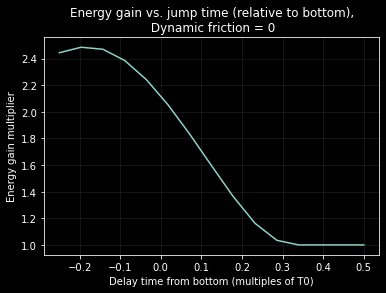

In [136]:
plt.plot(tdelays, np.array(Efs[0]) / e0) # tdelays # Ffs / G
plt.xlabel('Delay time from bottom (multiples of T0)')
# plt.xlabel('Acceleration from friction (gees)')
plt.ylabel('Energy gain multiplier')
plt.title('Energy gain vs. jump time (relative to bottom),\n Dynamic friction = 0')
# plt.title('Energy gain vs. friction')
plt.grid(True, alpha=0.1)

In [ ]:
plt.pcolor(tdelays, np.log10(vmax_mults), [Ef / np.mean(Ef) for Ef in Efs])
plt.figure()
plt.pcolor(tdelays, np.log10(vmax_mults), np.array(Efs) / e0)
cb = plt.colorbar()
plt.xlabel('Timing delay (T0 multiples)')
plt.ylabel('log10(Angular velocity multiplier)')
cb.set_label('Energy gain', labelpad=-1) 


Text(0.5, 1.0, 'Energy gain vs. relative mass of middle link')

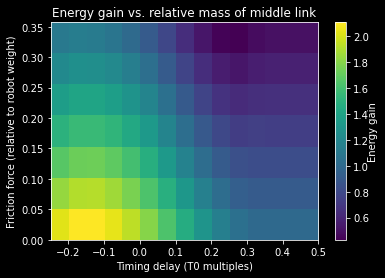

In [127]:
# plt.pcolormesh(tdelays, Ffs / 9.8, np.array(Efs) / e0)
# plt.imshow(np.stack(np.meshgrid(tdelays, Ffs / 9.8) + [np.array(Efs) / e0], axis=-1))
plt.imshow(np.array(Efs) / e0, extent=[np.amin(tdelays), np.amax(tdelays), np.amin(Ffs / 0.65 / G), np.amax(Ffs / 0.65 / G)], aspect='auto', origin='lower')
# ax = plt.gca()
# ax.set_xticklabels(tdelays)
# ax.set_yticklabels(Ffs / 9.8)
# plt.yscale('log')
cb = plt.colorbar()
plt.xlabel('Timing delay (T0 multiples)')
plt.ylabel('Friction force (relative to robot weight)')
cb.set_label('Energy gain', labelpad=-1)
plt.title('Energy gain vs. relative mass of middle link')


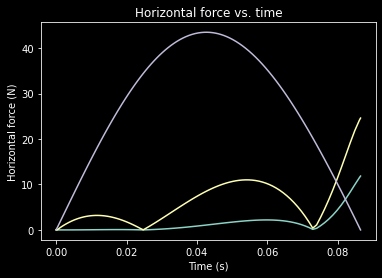

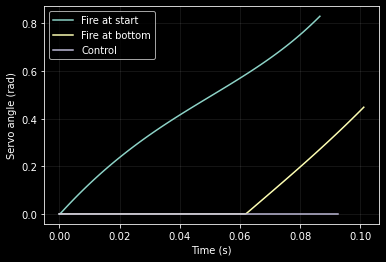

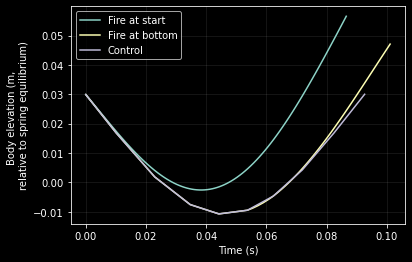

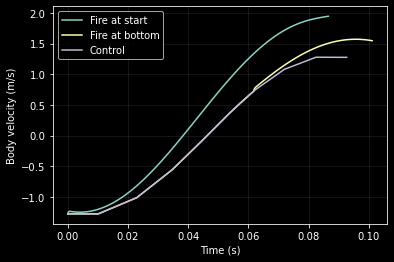

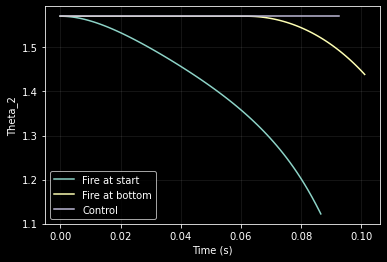

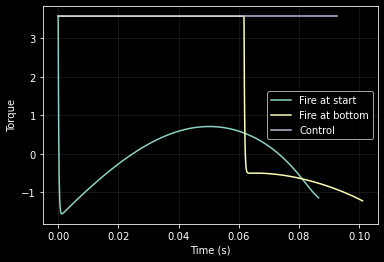

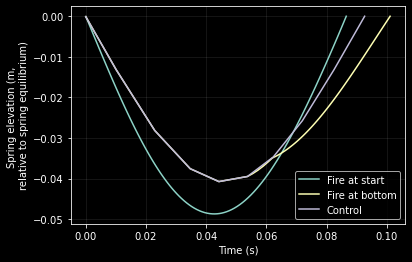

---------------------------


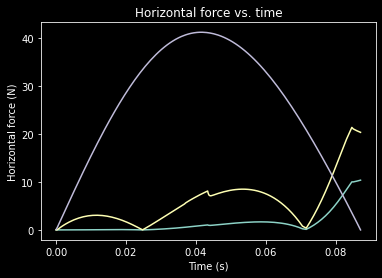

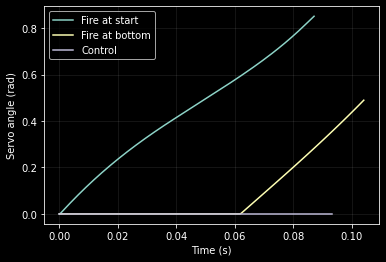

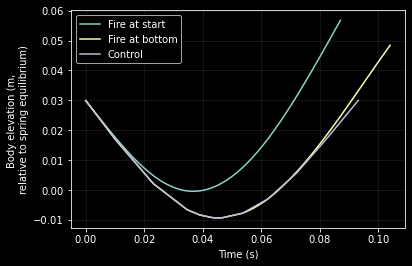

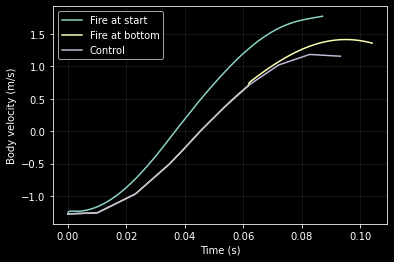

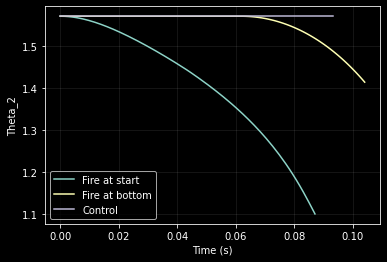

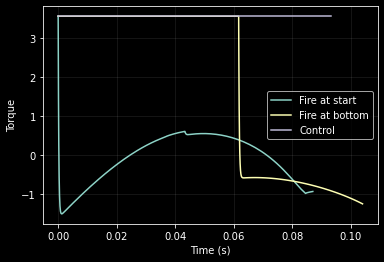

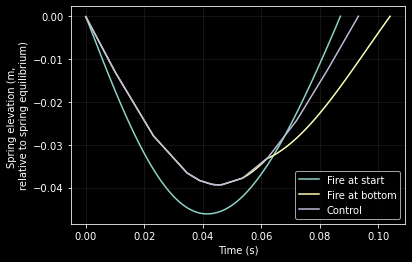

---------------------------


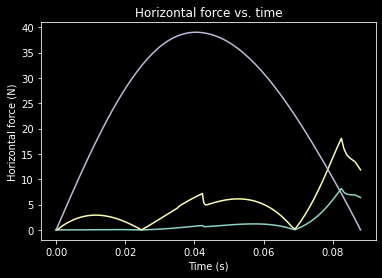

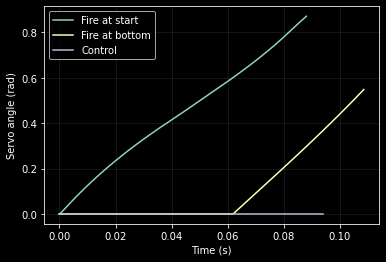

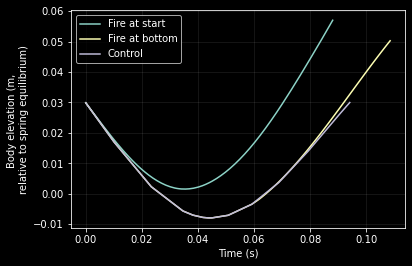

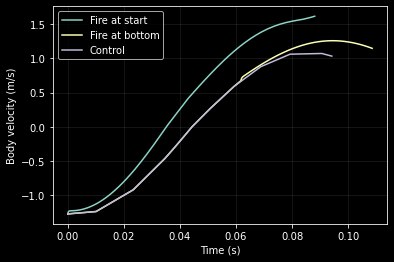

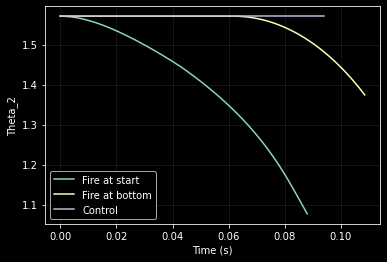

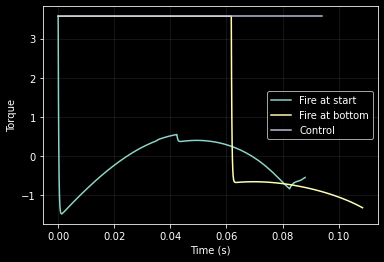

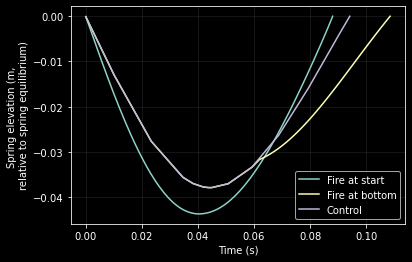

---------------------------


In [137]:
for soli in [0, int(len(solss) / 2), -1]:
    sols = solss[soli]
    end_2 = int(len(sols) / 2)
    ylabels = ['Servo angle (rad)', 'Body elevation (m, \nrelative to spring equilibrium)', 'Body velocity (m/s)', 'Theta_2', 'Torque', 'Spring elevation (m, \nrelative to spring equilibrium)']
    sol_ts = [sol.t for sol in sols]
    sol_vars = [np.concatenate((sol.y, P.nl_ode(False)(sol.t, sol.y)), axis=0) for sol in sols] # [t1, z1, dz1, dz2] [t1, t2, dt1, tau_1, Fsp, z1, dz1, z2]
    sol_is = [0, 1, 2, 5, 7, -1]
    
    plt.figure(soli * 10 - 1)
    R1 = P.R1
    Fh = np.cos(math.pi - (sol_vars[0][5,:] - sol_vars[0][0,:])) * np.cos(sol_vars[0][5,:]) * sol_vars[0][7,:] / R1
    Fv = np.cos(math.pi - (sol_vars[0][5,:] - sol_vars[0][0,:])) * np.sin(sol_vars[0][5,:]) * sol_vars[0][7,:] / R1
    plt.plot(sol_ts[0], np.abs(Fh))
    plt.plot(sol_ts[0], np.abs(Fv))
    plt.plot(sol_ts[0], np.abs(sol_vars[0][8,:]))
    plt.title('Horizontal force vs. time')
    plt.xlabel('Time (s)')
    plt.ylabel('Horizontal force (N)')
    
    plt.show()
    
    for ii, i in enumerate(sol_is):
        plt.figure(soli * 10 + ii)
        plt.plot(sol_ts[0], sol_vars[0][i,:])
        plt.plot(sol_ts[end_2], sol_vars[end_2][i,:])
        plt.plot(sol_ts[-1], sol_vars[-1][i,:])
        plt.xlabel('Time (s)')
        plt.ylabel(ylabels[ii])
        plt.grid(True, alpha=0.1)

        plt.legend(['Fire at start', 'Fire at bottom', 'Control'])
        
        plt.show()
    
    print('---------------------------')

In [91]:
# plt.ioff()
Ediff = Ef / E0[:, np.newaxis, np.newaxis]
for ei, (ef, ef1, e0) in enumerate(zip(Ef, Ef1, E0)):
#     plt.figure(figsize=(9,6))
#     plt.pcolor(Vmax, K, (Xf[:,:,6] - Xf[:,:,8])) # / Z2_0[:,np.newaxis]) # Y = spring constants, X = 
#     plt.ylabel('Spring constant (N/m)')
#     plt.xlabel('Max velocity (rad/s)')
#     plt.colorbar(label='Final piston width (m)')
#     plt.title('Final piston width vs. spring constant & max velocity (E0=%.3f)' % e0)

    fig = plt.figure(figsize=(9,6))
    plt.pcolor(Vmax, K, ef1 / ef) # , vmin=np.amin(Ediff), vmax=np.amax(Ediff)) # / Z2_0[:,np.newaxis]) # Y = spring constants, X = 
    plt.ylabel('Spring constant (N/m)')
    plt.xlabel('Max velocity (rad/s)')
    plt.colorbar(label='Final energy (J)') # , mappable=cm.ScalarMappable(norm=colors.Normalize(np.amin(Ediff), np.amax(Ediff)), cmap=cm.get_cmap('viridis')))
    plt.title('Final energy vs. spring constant & max velocity (E0=%.3f)' % e0)
    plt.savefig('/Users/derek-lam/dev/robots/pendbot/proc/energetics/direct/%.3f.png' % e0)
    plt.close(fig)

# plt.ion()

<ipython-input-91-0fcc22a7db27>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(Vmax, K, ef1 / ef) # , vmin=np.amin(Ediff), vmax=np.amax(Ediff)) # / Z2_0[:,np.newaxis]) # Y = spring constants, X =


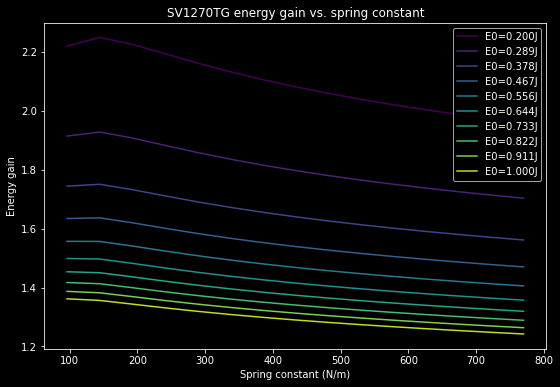

In [51]:
# plt.ioff()
Ediff = Ef / E0[:, np.newaxis, np.newaxis]
fig = plt.figure(figsize=(9,6))
cmap = cm.get_cmap('viridis').colors
for ei, (ef, e0) in enumerate(zip(Ef, E0)):
#     plt.figure(figsize=(9,6))
#     plt.pcolor(Vmax, K, (Xf[:,:,6] - Xf[:,:,8])) # / Z2_0[:,np.newaxis]) # Y = spring constants, X = 
#     plt.ylabel('Spring constant (N/m)')
#     plt.xlabel('Max velocity (rad/s)')
#     plt.colorbar(label='Final piston width (m)')
#     plt.title('Final piston width vs. spring constant & max velocity (E0=%.3f)' % e0)

    plt.plot(K, ef[:,1] / e0, c=cmap[int(ei / len(E0) * len(cmap))]) # pcolor(Vmax, K, ef) # , vmin=np.amin(Ediff), vmax=np.amax(Ediff)) # / Z2_0[:,np.newaxis]) # Y = spring constants, X = 
    plt.ylabel('Energy gain')
    plt.xlabel('Spring constant (N/m)')
    plt.title('SV1270TG energy gain vs. spring constant')

plt.legend(['E0=%.3fJ' % e for e in E0])
# plt.ion()

In [36]:
for ei, (ef, e0) in enumerate(zip(Ef, E0)):
#     with open('/Users/derek-lam/dev/robots/pendbot/proc/energetics/%.3f.csv' % e0) as f:
#         w = csv.writer(f)
    Z2_0 = (G * M + np.sqrt((G * M) ** 2 + 2 * K * e0)) / K
    ef_ = np.insert(ef, 0, [Tstall, Vmax], axis=0)
    np.savetxt('/Users/derek-lam/dev/robots/pendbot/proc/energetics/savox/%.3f.csv' % e0, np.insert(ef_, 0, np.insert([Z2_0, K], 0, np.zeros((2, 2)) * np.nan, axis=1), axis=1), delimiter=',')

Text(0.5, 1.0, 'Expansion amount vs. spring constant & max velocity')

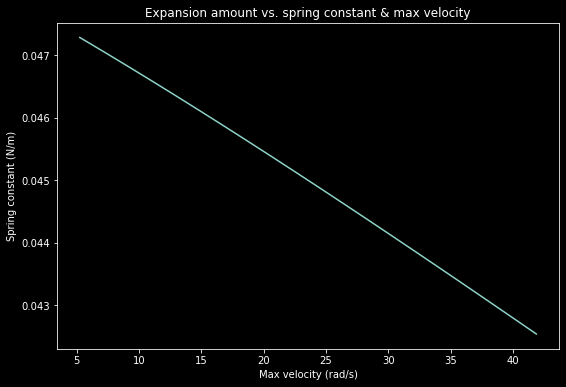

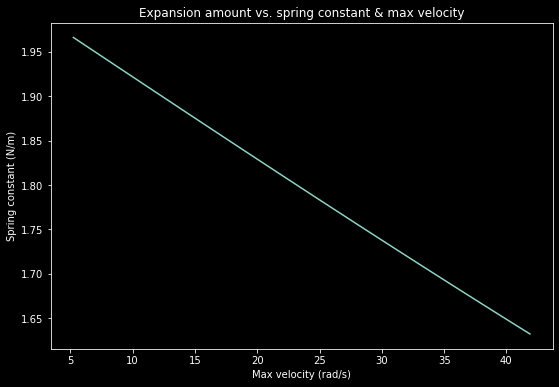

In [440]:
plt.figure(figsize=(9,6))
plt.plot(Vmax, np.squeeze(Xf[:,:,6] - Xf[:,:,8])) # / Z2_0[:,np.newaxis]) # Y = spring constants, X = 
plt.ylabel('Spring constant (N/m)')
plt.xlabel('Max velocity (rad/s)')
# plt.colorbar(label='Expansion amount')
plt.title('Expansion amount vs. spring constant & max velocity')

plt.figure(figsize=(9,6))
plt.plot(Vmax, np.squeeze(Ef / E0)) # / Z2_0[:,np.newaxis]) # Y = spring constants, X = 
plt.ylabel('Spring constant (N/m)')
plt.xlabel('Max velocity (rad/s)')
# plt.colorbar(label='Expansion amount')
plt.title('Expansion amount vs. spring constant & max velocity')

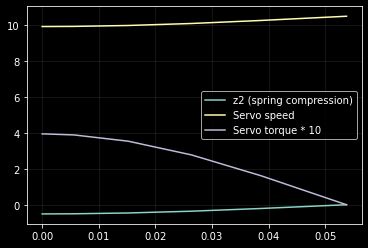

In [399]:
plt.plot(sol.t, z2 * 10)
plt.plot(sol.t, dt1)
plt.plot(sol.t, tau_1 * 10)
plt.legend(['z2 (spring compression)', 'Servo speed', 'Servo torque * 10'])
plt.grid(True, alpha=0.1)

In [222]:
Xf = np.empty((K.shape[0], Vmax.shape[0], 3))
Xf[:] = np.nan
Z2_0 = (G * M + np.sqrt((G * M) ** 2 + 2 * K * E0)) / K
for ki, (k, z2_0_) in enumerate(zip(K, Z2_0)):
    for vi, (vmax_, t0) in enumerate(zip(Vmax, Tstall)):
        T0 = 2 * math.pi * math.sqrt(M / k)
        vmax = vmax_ * R
        F0 = t0 / R
        z2_0 = min(z2_0_, F0 / k)
#         if F0 / k < z2_0_:
#         print(F0 / k, z2_0_)
#         print(k * z2_0 ** 2 / 2 - G * M * z2_0)
        Fl_0 = z2_0 * k

        # 
    
        A = np.array([
            # z1', z2, z1
            [0, -k / M, 0], # z1''
            [1, -k * vmax / F0, 0], # z2'
            [1, 0, 0], # z1'
        ])
        B = np.array([-G, -vmax, 0])[...,np.newaxis]
        C = np.eye(3)
        D = np.zeros((3, 1))

        SS = control.StateSpace(A, B, C, D)
        T = np.linspace(0, T0 * 2) # two natural periods to sim the whole thing
        Tout, _, xout = control.forced_response(SS, T, np.ones(T.shape[0]), X0=[0, -z2_0, -z2_0])
    #     [plt.plot(Tout, x) for x in xout]

        if np.any(xout[1] > 0):
            xf = np.nonzero((xout[1, 1:] > 0) ^ (xout[1, :-1] > 0))[0][0]
            x_ = np.dot(A, xout) + B
#             print((x_[2] - x_[1]) / vmax)
#             plt.plot((Tout / T0)[:xf], (xout[2] - xout[1])[:xf]) # ((-k / M * xout[1]))[:xf])
            xfi = lambda l: (l[xf + 1] - l[xf]) * (-xout[1][xf]) / (xout[1][xf + 1] - xout[1][xf]) + l[xf]
            Xf[ki, vi] = [xfi(x) for x in xout]
#             xi = lambda j: lambda t: np.interp(t, Tout, xout[j])
#             tf = scipy.optimize.fsolve(xi(1), T0 / 3)
#             Vf[ki, vi] = xi(0)(tf)
#         break
#     break

<ipython-input-212-1834de088693>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(Vmax, K, (Xf[:,:,2] - Xf[:,:,1])) # / Z2_0[:,np.newaxis]) # Y = spring constants, X =
<ipython-input-212-1834de088693>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(Vmax, K, DE) # Y = spring constants, X =


Text(0.5, 1.0, 'Single-jump energy gain (E0 = 0.33J, R=0.040m, M=0.350kg)')

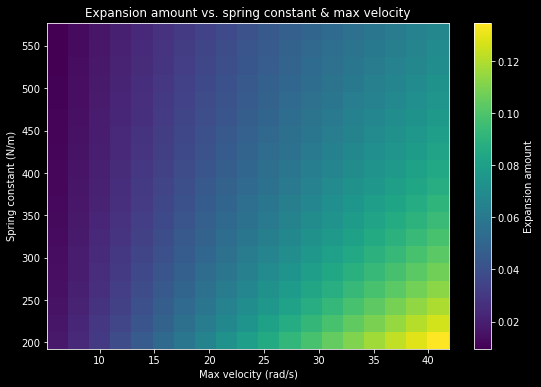

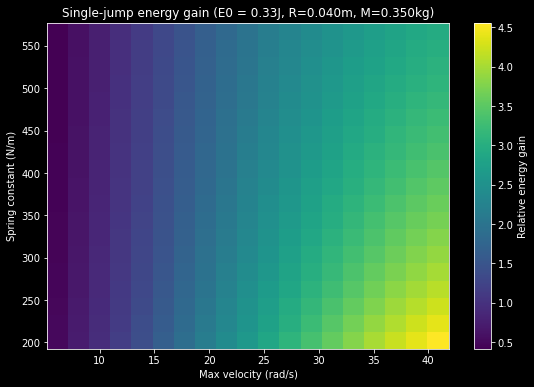

In [212]:
DE = (M * (Xf[:,:,0] ** 2 / 2 + Xf[:,:,2] * G) - E0) / E0
plt.figure(figsize=(9,6))
plt.pcolor(Vmax, K, (Xf[:,:,2] - Xf[:,:,1])) # / Z2_0[:,np.newaxis]) # Y = spring constants, X = 
plt.ylabel('Spring constant (N/m)')
plt.xlabel('Max velocity (rad/s)')
plt.colorbar(label='Expansion amount')
plt.title('Expansion amount vs. spring constant & max velocity')

plt.figure(figsize=(9,6))
plt.pcolor(Vmax, K, DE) # Y = spring constants, X = 
plt.ylabel('Spring constant (N/m)')
plt.xlabel('Max velocity (rad/s)')
plt.colorbar(label='Relative energy gain')
plt.title('Single-jump energy gain (E0 = %.2fJ, R=%.3fm, M=%.3fkg)' % (E0, R, M))

In [77]:
R1, R2, W = (0.04, 0.03, 0.05)
def nl_ode(k, vmax, tau_stall, Ff = 0, d_ = True, tdelay = 0):
    def nl_ode_(t, x):
        t1, z1, dz1 = x
        # derived parameters
        z2 = z1 - (R1 * np.sin(t1))

        Fsp = -k * z2
        
        # Fj = Fsp
        # Fj = tau_1 / R1 * (math.cos(t1) - math.cos(t2) * math.sin(phi))
        # =>
        tau_1 = Fsp * R1 / np.cos(t1)
        # ---
        # tau_1 = tau_stall * (1 - dt1 / vmax)
        # =>
        dt1 = (1 - tau_1 / tau_stall) * vmax
#         print(t1, dt1)
        if dt1.size > 1:
            dt1[((t1 <= 0) & (dt1 < 0)) | (t < tdelay)] = 0
        elif (t1 <= 0 and dt1 < 0) or t < tdelay: # second clause for endstop # t2_arg >= 1 or 
            dt1 = 0

        # solving for derivatives
        if d_:
            return [
                dt1, # dt1
                dz1, # dz1
                Fsp / M - G - Ff * np.sign(dz1) # ddz1
            ]
        else:
            return [t1, dt1, tau_1, Fsp, z1, dz1, z2]
    
    return nl_ode_ # lambda _, x: (x)

    # IGNORE:
#     tau_2 = math.sin(phi) * tau_1 * R2 / R1
#     dz1 = dz2 + (dt1 * R1 * math.cos(t1) + dt2 * R2 * math.cos(t2))
#     ddz1 = ddz2 + (
#         ddt1 * R1 * math.cos(t1) - (dt1 ** 2) * R1 * math.cos(t1) * math.sin(t1)
#         + ddt2 * R2 * math.cos(t2) - (dt2 ** 2) * R2 * math.cos(t2) * math.sin(t2)
#     )

In [4]:
# see below when the middle node is not massless
R1, R2, W = (0.04, 0.03, 0.05)
def nl_ode(k, vmax, tau_stall, Ff = 0, d_ = True, tdelay = 0):
    def nl_ode_(t, x):
        t1, z1, dz1 = x
        # derived parameters
        t2_arg = (W - R1 * np.cos(t1)) / R2
        t2 = np.arccos(np.minimum(t2_arg, 1))
        phi = t2 + (math.pi - t1)
        z2 = z1 - (R1 * np.sin(t1) + R2 * np.sin(t2))

        Fsp = -k * z2
        
        # Fj = Fsp
        # Fj = tau_1 / R1 * (math.cos(t1) - math.cos(t2) * math.sin(phi))
        # =>
        tau_1 = Fsp * R1 / (np.cos(t1) - np.cos(t2) * np.sin(phi))
        # ---
        # tau_1 = tau_stall * (1 - dt1 / vmax)
        # =>
        dt1 = (1 - tau_1 / tau_stall) * vmax
        zeroed = (t2_arg >= 1) | ((t1 <= 0) & (dt1 < 0)) | (t < tdelay) # np.logical_or(t2_arg >= 1, np.logical_and(t1 <= 0, dt1 < 0)) # second clause for endstop
        if dt1.size > 1:
            dt1[zeroed] = 0
        elif zeroed:
            dt1 = 0

        # solving for derivatives
        if d_:
            return [
                dt1, # dt1
                dz1, # dz1
                Fsp / M - G - Ff * np.sign(dz1) # ddz1
            ]
        else:
            return [t1, dt1, tau_1, Fsp, z1, dz1, z2] # [phi, t1, dt1, tau_1, Fsp, t2, z1, dz1, z2]
    
    return nl_ode_ # lambda _, x: 

    # IGNORE:
#     tau_2 = math.sin(phi) * tau_1 * R2 / R1
#     dz1 = dz2 + (dt1 * R1 * math.cos(t1) + dt2 * R2 * math.cos(t2))
#     ddz1 = ddz2 + (
#         ddt1 * R1 * math.cos(t1) - (dt1 ** 2) * R1 * math.cos(t1) * math.sin(t1)
#         + ddt2 * R2 * math.cos(t2) - (dt2 ** 2) * R2 * math.cos(t2) * math.sin(t2)
#     )

In [23]:
# k = 385
# T0 = 2 * math.pi * math.sqrt(M / k)
# z2_0 = (G * M + np.sqrt((G * M) ** 2 + 2 * k * E0)) / k
# tstall = Vref * (Pmax / (Vref / 2) ** 2)

K = np.linspace(385 / 4, 385 * 2, 15)
Vmax = np.linspace(Vref / 2, Vref * 3, 15) # rad/s # np.array([10.472, 9.52]) # 
Tstall = Vmax * (Pmax / (Vmax / 2) ** 2) # np.array([3.000, 3.503]) # 
E0 = np.linspace(0.2, 1.0, 10)

# Xf = np.empty((E0.shape[0], K.shape[0], Vmax.shape[0], 7))
# Xf[:] = np.nan
Ef = np.empty((E0.shape[0], K.shape[0], Vmax.shape[0]))
Ef[:] = np.nan
for ei, e0 in enumerate(E0):
    Z2_0 = (G * M + np.sqrt((G * M) ** 2 + 2 * K * e0)) / K
    for ki, (k, z2_0) in enumerate(zip(K, Z2_0)):
        for vi, (vmax, tstall) in enumerate(zip(Vmax, Tstall)):
            T0 = 2 * math.pi * math.sqrt(M / k)
            f_stop = lambda t, x: nl_ode(k, vmax, tstall, 0, False)(0, x)[-1] # extract z2
            f_stop.terminal = True
            dz1_z2_0 = R2 # A HACK: the proper way is to calculate z1 given t0, R1, R2 and W, but it's just too much of a pain atm. FIXME
            sol = scipy.integrate.solve_ivp(nl_ode(k, vmax, tstall), (0, T0 * 2), [0, -z2_0 + dz1_z2_0, 0], rtol=1E-5, events=f_stop)
#             params = nl_ode(k, vmax, tstall, False)(0, sol.y)
# #             [phi, t1, dt1, tau_1, Fsp, t2, z1, dz1, z2] = params
#             [t1, dt1, tau_1, Fsp, z1, dz1, z2] = params
            [t1, z1, dz1] = sol.y
            Em = dz1 ** 2 * M / 2 + (z1 - dz1_z2_0) * G * M
#             Xf[ei, ki, vi] = np.array(params)[:,-1] # sol.y[:,-1]
            Ef[ei, ki, vi] = Em[-1]
        
#             plt.figure(1)
#             plt.plot(sol.t)
#             plt.plot(sol.t, np.abs(z2 ** 2 * k / 2))
#             plt.plot(sol.t, dz1 ** 2 * M / 2)
#             plt.plot(sol.t, (z1 - dz1_z2_0) * G * M)

#             plt.figure(3)
#             plt.plot(sol.t, t1)
#             plt.figure(2)
#             plt.plot(sol.t, dz1)

# plt.figure(1)
# plt.xlabel('Time')
# plt.ylabel('Piston width')